In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from transformers import BertTokenizer, BertModel
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.auto import tqdm

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
df = pd.read_excel("/content/CrisisMMD_informative.xlsx")
df = df.dropna(subset=['tweet_text', 'image_path', 'label'])
df['label'] = df['label'].astype(int)

# Train/Validation split
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Image transforms
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [5]:
class MultimodalDataset(Dataset):
    def __init__(self, dataframe, tokenizer, transform):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        encoding = self.tokenizer(row['tweet_text'], padding='max_length', truncation=True,
                                  max_length=128, return_tensors="pt")
        image = Image.open(row['image_path']).convert("RGB")
        image = self.transform(image)
        label = torch.tensor(row['label'], dtype=torch.long)

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'image': image,
            'label': label
        }

In [6]:
train_loader = DataLoader(MultimodalDataset(train_df, tokenizer, image_transform), batch_size=32, shuffle=True)
val_loader = DataLoader(MultimodalDataset(val_df, tokenizer, image_transform), batch_size=32)

In [7]:
class MultimodalModel(nn.Module):
    def __init__(self):
        super(MultimodalModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.cnn = models.resnet50(pretrained=True)
        self.cnn.fc = nn.Identity()  # Remove final classification layer

        self.text_fc = nn.Linear(768, 512)
        self.image_fc = nn.Linear(2048, 512)

        self.attention = nn.MultiheadAttention(embed_dim=512, num_heads=4, batch_first=True)

        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, input_ids, attention_mask, image):
        text_feat = self.bert(input_ids=input_ids, attention_mask=attention_mask).pooler_output
        text_feat = self.text_fc(text_feat)

        image_feat = self.cnn(image)
        image_feat = self.image_fc(image_feat)

        combined = torch.stack([text_feat, image_feat], dim=1)  # Shape: (B, 2, 512)
        attn_output, _ = self.attention(combined, combined, combined)
        fused = attn_output.mean(dim=1)  # Pooling across modalities

        return self.classifier(fused)


In [8]:
model = MultimodalModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 177MB/s]


In [9]:
def train_epoch(model, dataloader):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in tqdm(dataloader, desc="Training", leave=False):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    return total_loss / len(dataloader), acc


In [10]:
def eval_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask, images)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return y_true, y_pred

In [11]:
EPOCHS = 5
train_losses, train_accuracies, val_accuracies = [], [], []
best_val_acc = 0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    train_loss, train_acc = train_epoch(model, train_loader)
    y_true, y_pred = eval_model(model, val_loader)
    val_acc = accuracy_score(y_true, y_pred)

    # Save best model
    if val_acc > best_val_acc:
        torch.save(model.state_dict(), "best_model.pth")
        best_val_acc = val_acc

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")



Epoch 1/5


Training:   0%|          | 0/341 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Train Loss: 0.5396, Train Acc: 0.7233, Val Acc: 0.7730

Epoch 2/5


Training:   0%|          | 0/341 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Train Loss: 0.3547, Train Acc: 0.8360, Val Acc: 0.7689

Epoch 3/5


Training:   0%|          | 0/341 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Train Loss: 0.1930, Train Acc: 0.9222, Val Acc: 0.7730

Epoch 4/5


Training:   0%|          | 0/341 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Train Loss: 0.1064, Train Acc: 0.9642, Val Acc: 0.7528

Epoch 5/5


Training:   0%|          | 0/341 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Train Loss: 0.0704, Train Acc: 0.9767, Val Acc: 0.7645


In [12]:
print("\n\n===== Final Evaluation =====")
report = classification_report(y_true, y_pred, output_dict=True, target_names=['Class 0', 'Class 1'])
df_report = pd.DataFrame(report).transpose()
print(df_report.to_string(float_format="{:.4f}".format))



===== Final Evaluation =====
              precision  recall  f1-score   support
Class 0          0.7956  0.8285    0.8117 1668.0000
Class 1          0.7096  0.6632    0.6856 1054.0000
accuracy         0.7645  0.7645    0.7645    0.7645
macro avg        0.7526  0.7459    0.7487 2722.0000
weighted avg     0.7623  0.7645    0.7629 2722.0000


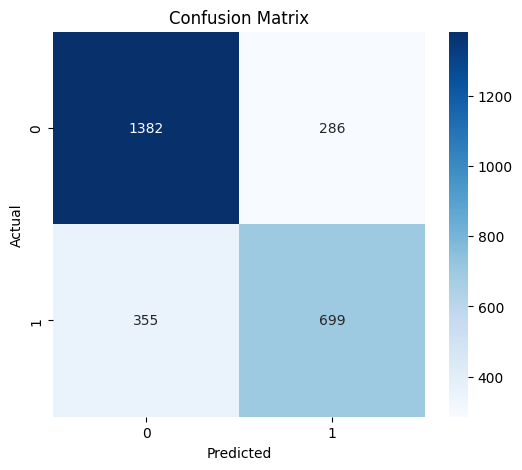

In [13]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

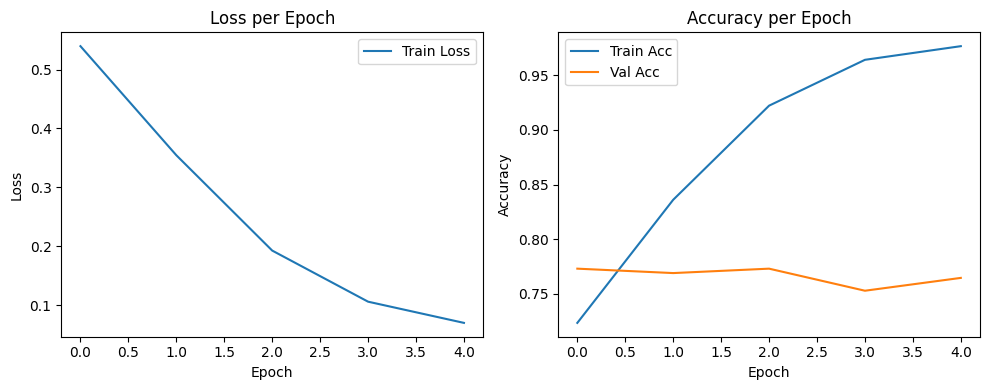

In [14]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()